In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [13]:
df = pd.read_csv("data.csv")

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.columns.tolist()

['User ID',
 'User Name',
 'Driver Name',
 'Car Condition',
 'Weather',
 'Traffic Condition',
 'key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'hour',
 'day',
 'month',
 'weekday',
 'year',
 'jfk_dist',
 'ewr_dist',
 'lga_dist',
 'sol_dist',
 'nyc_dist',
 'distance',
 'bearing']

In [17]:
drop_cols = ['User ID', 'User Name', 'Driver Name', 'key']
df.drop(columns=drop_cols, inplace=True)

In [18]:
df.dropna(inplace=True)
df.shape

(499995, 22)

In [19]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers_iqr(df, ['fare_amount', 'distance', 'passenger_count'])

In [22]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [24]:
df = pd.get_dummies(df, columns=['Car Condition', 'Weather', 'Traffic Condition'], drop_first=True)

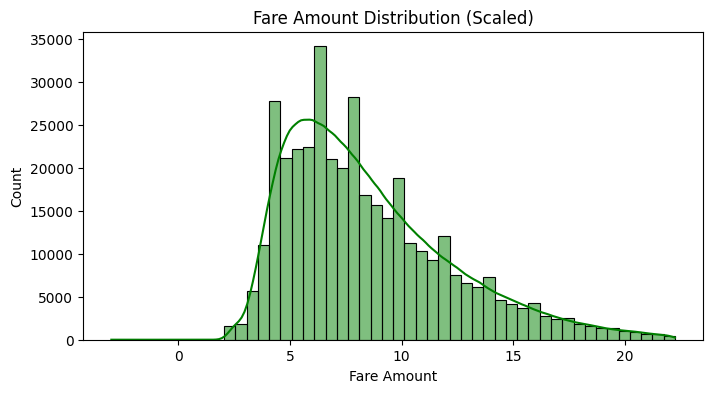

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(df['fare_amount'], kde=True, bins=50, color='green')
plt.title("Fare Amount Distribution (Scaled)")
plt.xlabel("Fare Amount")
plt.show()

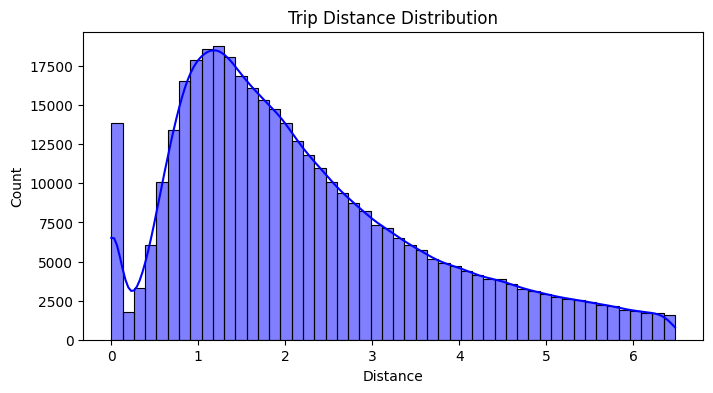

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(df['distance'], kde=True, bins=50, color='blue')
plt.title("Trip Distance Distribution")
plt.xlabel("Distance")
plt.show()

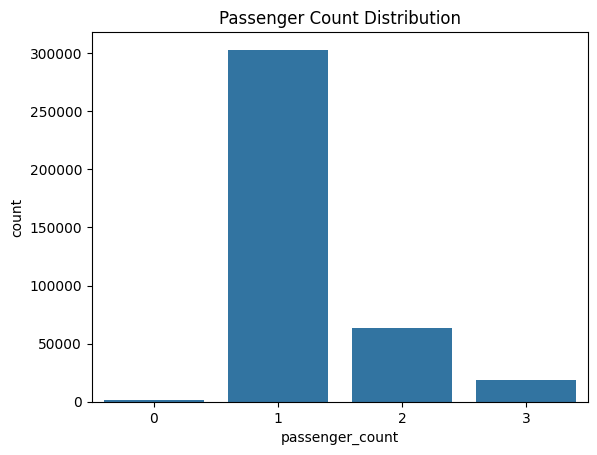

In [30]:
sns.countplot(x='passenger_count', data=df)
plt.title("Passenger Count Distribution")
plt.show()

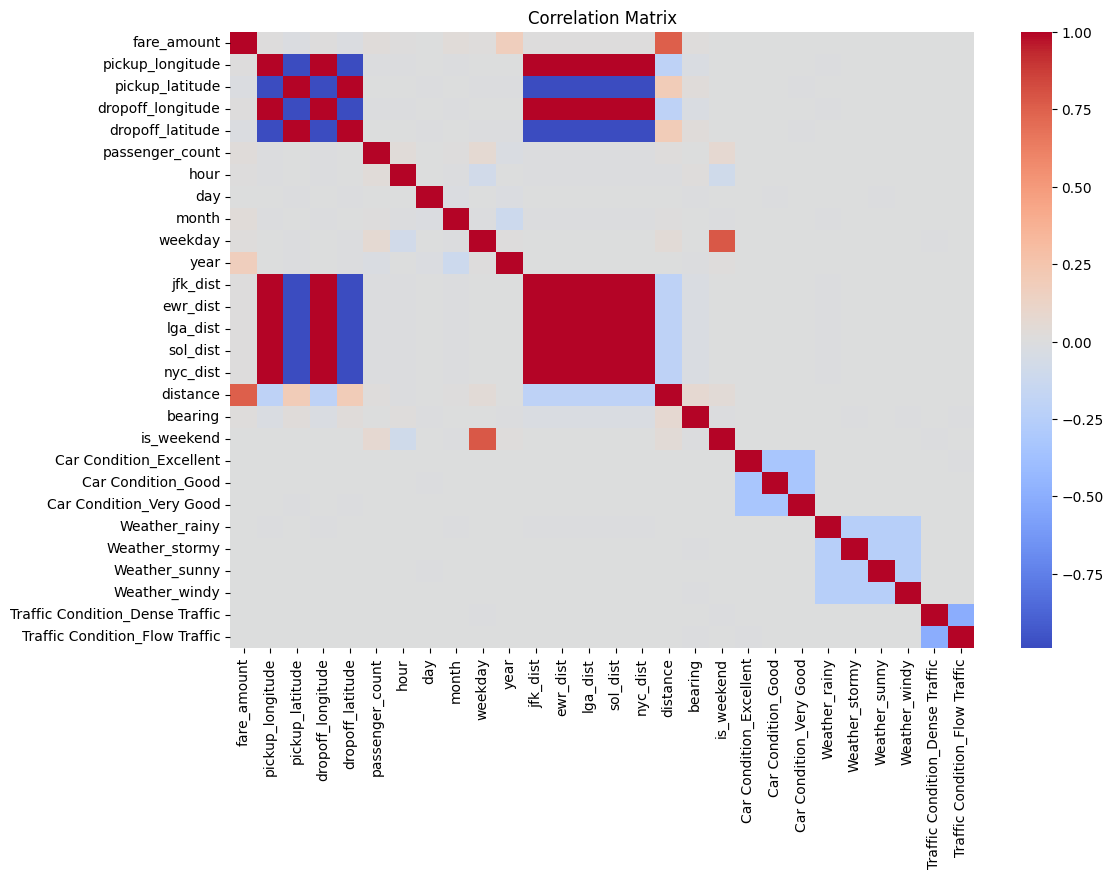

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [37]:
sample_df = df.sample(50)
heat_data = sample_df[['pickup_latitude', 'pickup_longitude']].values.tolist()

In [39]:
from geopy.distance import geodesic

df['distance_km'] = df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)

In [40]:
import numpy as np

def calculate_bearing(lat1, lon1, lat2, lon2):
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    x = np.sin(dLon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - \
        np.sin(lat1) * np.cos(lat2) * np.cos(dLon)
    bearing = np.arctan2(x, y)
    return (np.degrees(bearing) + 360) % 360

df['bearing'] = df.apply(lambda row: calculate_bearing(
    row['pickup_latitude'], row['pickup_longitude'],
    row['dropoff_latitude'], row['dropoff_longitude']
), axis=1)


In [41]:
df["bearing"]

0         163.367686
2         218.453490
3         349.916552
4          35.983729
5          46.536838
             ...    
499989    234.483263
499991    336.058971
499995    122.801541
499996    221.122754
499999    155.831219
Name: bearing, Length: 387250, dtype: float64

In [42]:
def direction_from_bearing(bearing):
    directions = ['North', 'North-East', 'East', 'South-East', 
                  'South', 'South-West', 'West', 'North-West']
    idx = int((bearing + 22.5) // 45) % 8
    return directions[idx]

df['direction'] = df['bearing'].apply(direction_from_bearing)


In [43]:
df['direction']

0              South
2         South-West
3              North
4         North-East
5         North-East
             ...    
499989    South-West
499991    North-West
499995    South-East
499996    South-West
499999    South-East
Name: direction, Length: 387250, dtype: object

C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_21176\1019617515.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='direction', order=['North', 'North-East', 'East', 'South-East',


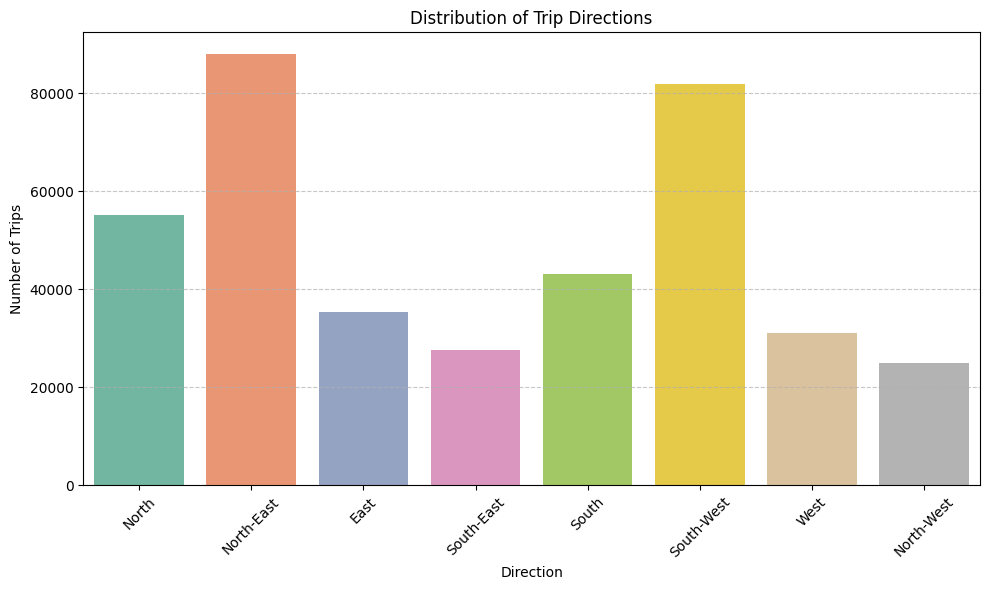

In [45]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='direction', order=['North', 'North-East', 'East', 'South-East',
                                             'South', 'South-West', 'West', 'North-West'], palette='Set2')

plt.title('Distribution of Trip Directions')
plt.xlabel('Direction')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_21176\2850481857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='direction', y='fare_amount',


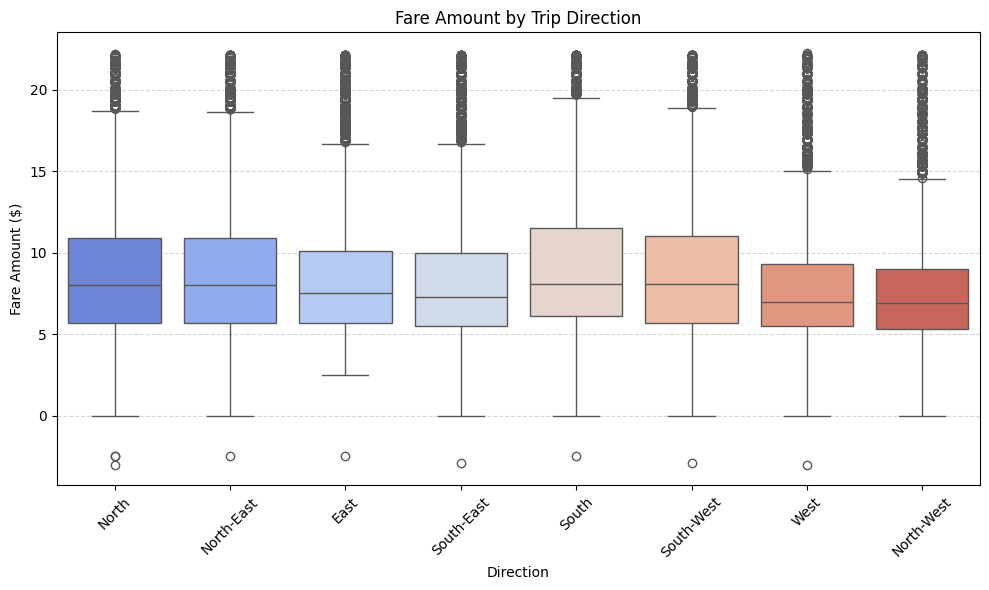

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='direction', y='fare_amount', 
            order=['North', 'North-East', 'East', 'South-East',
                   'South', 'South-West', 'West', 'North-West'], palette='coolwarm')

plt.title('Fare Amount by Trip Direction')
plt.xlabel('Direction')
plt.ylabel('Fare Amount ($)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [47]:
from geopy.distance import geodesic

df['distance_km'] = df.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).km, axis=1)


C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_21176\857641588.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='direction', y='distance_km',
C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_21176\857641588.py:11: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CRIZMA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


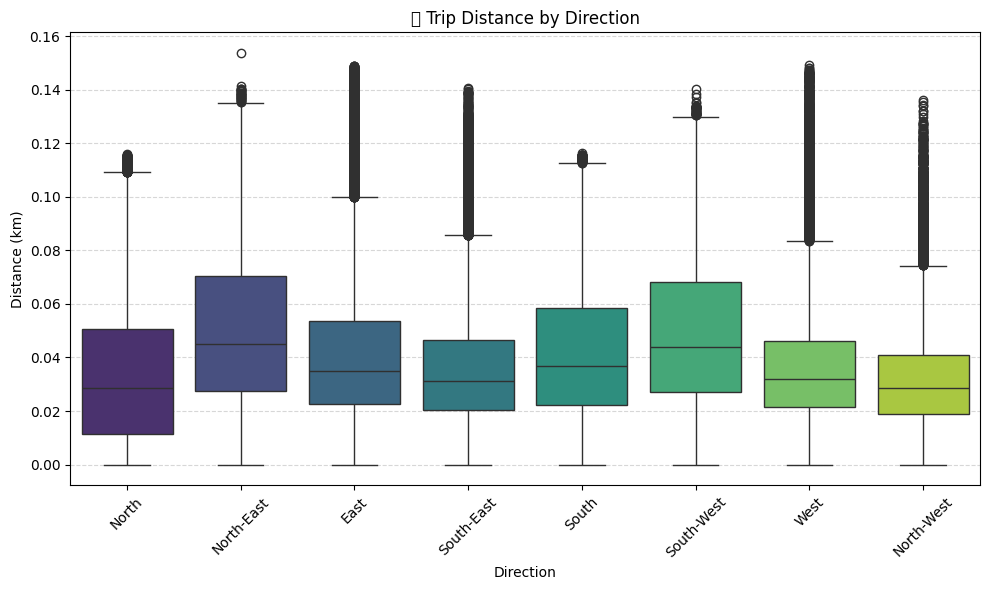

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='direction', y='distance_km', 
            order=['North', 'North-East', 'East', 'South-East',
                   'South', 'South-West', 'West', 'North-West'], palette='viridis')

plt.title('📏 Trip Distance by Direction')
plt.xlabel('Direction')
plt.ylabel('Distance (km)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


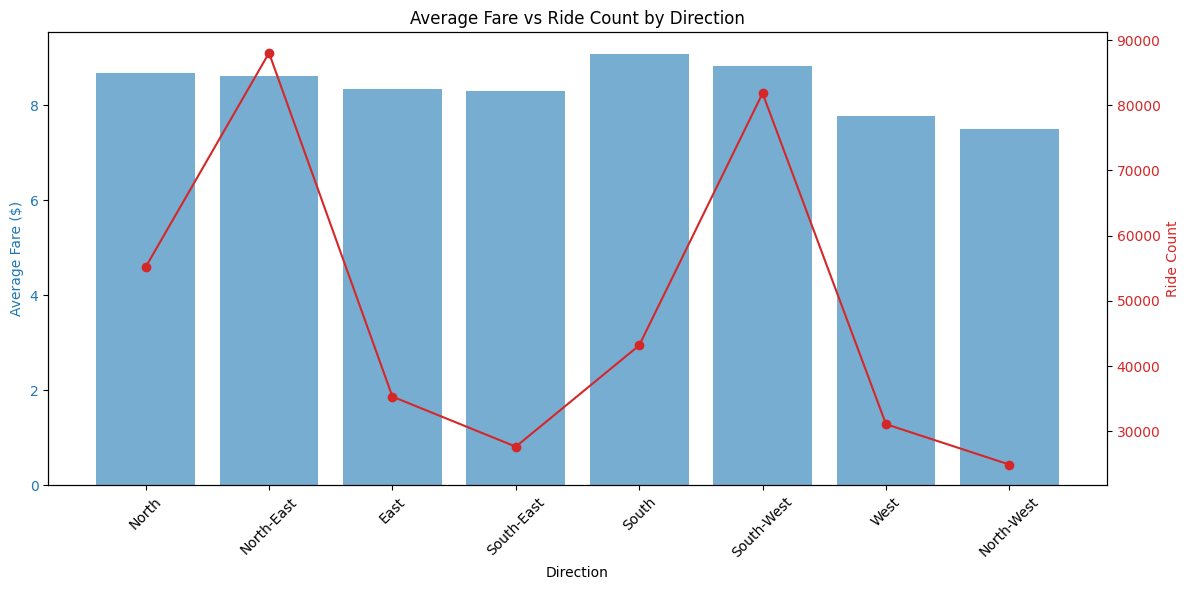

In [50]:
grouped = df.groupby('direction').agg({
    'fare_amount': 'mean',
    'distance_km': 'mean',
    'direction': 'count'
}).rename(columns={'direction': 'ride_count'})

grouped = grouped.reindex(['North', 'North-East', 'East', 'South-East',
                           'South', 'South-West', 'West', 'North-West'])

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Direction')
ax1.set_ylabel('Average Fare ($)', color=color)
ax1.bar(grouped.index, grouped['fare_amount'], color=color, alpha=0.6, label='Avg Fare')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:red'
ax2.set_ylabel('Ride Count', color=color)
ax2.plot(grouped.index, grouped['ride_count'], color=color, marker='o', label='Ride Count')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Average Fare vs Ride Count by Direction')
plt.grid(axis='x', linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()
